In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plot
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load dataset
# Pastikan file 'House Price Prediction.csv' ada di direktori yang sama
df = pd.read_csv('Housing.csv')

print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

Shape of dataset: (21613, 21)

First 5 rows:
           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7229300521  20141013T000000  231300.0         2       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr

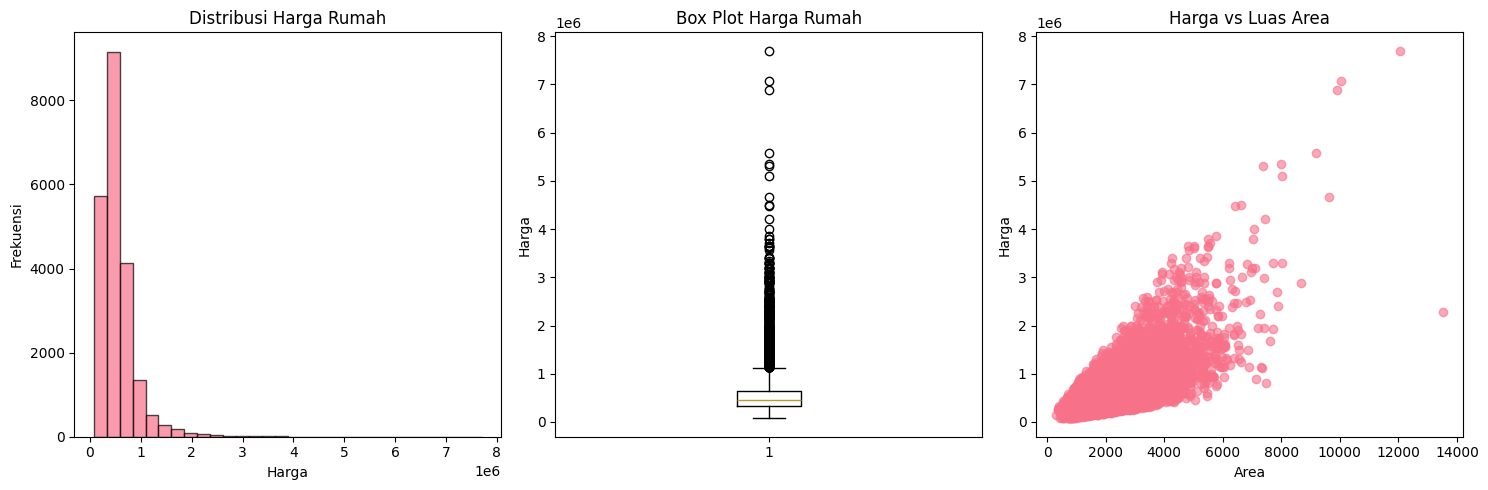

In [3]:
# Visualisasi distribusi harga
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribusi Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

plt.subplot(1, 3, 2)
plt.boxplot(df['price'])
plt.title('Box Plot Harga Rumah')
plt.ylabel('Harga')

plt.subplot(1, 3, 3)
plt.scatter(df['sqft_living'], df['price'], alpha=0.6)
plt.title('Harga vs Luas Area')
plt.xlabel('Area')
plt.ylabel('Harga')

plt.tight_layout()
plt.show()

In [4]:
# Buat copy untuk preprocessing
df_processed = df.copy()

# Handle categorical variables
label_encoders = {}
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != 'Price':  # Jangan encode target variable jika string
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

print("Categorical columns encoded:", list(categorical_cols))
print("\nProcessed dataset shape:", df_processed.shape)
print("\nProcessed dataset head:")
print(df_processed.head())

Categorical columns encoded: ['date']

Processed dataset shape: (21613, 21)

Processed dataset head:
           id  date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  7229300521   164  231300.0         2       1.00         1180      5650   
1  6414100192   220  538000.0         3       2.25         2570      7242   
2  5631500400   290  180000.0         2       1.00          770     10000   
3  2487200875   220  604000.0         4       3.00         1960      5000   
4  1954400510   283  510000.0         3       2.00         1680      8080   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     2.0           0     0  ...      7        2170            400      1951   
2     1.0           0     0  ...      6         770              0      1933   
3     1.0           0     0  ...      7        1050            910      1965   
4     1.0           0     0  ...    

In [5]:
# Definisi features dan target
target_col = 'price'
# feature_cols = [col for col in df_processed.columns if col != target_col]

feature_cols = ['sqft_living', 'lat', 'grade', 'long']

X = df_processed[feature_cols]
y = df_processed[target_col]

print("Features:", feature_cols)
print("Target:", target_col)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features: ['sqft_living', 'lat', 'grade', 'long']
Target: price
X shape: (21613, 4)
y shape: (21613,)

Training set: 17290 samples
Test set: 4323 samples


In [6]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print("Mean of scaled training data:", np.mean(X_train_scaled, axis=0).round(3))
print("Std of scaled training data:", np.std(X_train_scaled, axis=0).round(3))

Features scaled successfully!
Mean of scaled training data: [-0. -0. -0.  0.]
Std of scaled training data: [1. 1. 1. 1.]


In [7]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Tentukan parameter grid
param_grid = {
    'n_estimators': [100, 200],         # 100 cukup stabil, 200 untuk jaga-jaga
    'max_depth': [10, None],            # 10 untuk menghindari overfitting, None untuk full depth
    'min_samples_split': [2, 5],        # default dan sedikit regularisasi
    'min_samples_leaf': [1, 2]          # default dan sedikit penghalus
}

# Buat model dasar
rf = RandomForestRegressor(random_state=42)

# Buat GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross validation
    scoring='neg_mean_squared_error',  # Atau 'r2' jika kamu ingin skor R^2
    n_jobs=-1,  # core CPU
    verbose=1
)

# Jalankan grid search
grid_search.fit(X_train_scaled, y_train)

# Ambil model terbaik
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Score (neg MSE):", grid_search.best_score_)

# Fit ke model terbaik
best_model.fit(X_train_scaled, y_train)



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (neg MSE): -21218611465.968204


RandomForestRegressor(min_samples_leaf=2, n_estimators=200, random_state=42)

In [8]:
import joblib

# Simpan model terbaik
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Simpan hasil GridSearchCV (termasuk skor dan param_grid)
joblib.dump(grid_search, 'grid_search_result.pkl')

print("✅ Model dan grid search result berhasil disimpan!")

✅ Model dan grid search result berhasil disimpan!


In [9]:
# Load model
best_model = joblib.load('best_random_forest_model.pkl')

# (Optional) Load seluruh hasil GridSearch
grid_search = joblib.load('grid_search_result.pkl')
print("Best Params:", grid_search.best_params_)
print("Best Score (neg MSE):", grid_search.best_score_)

Best Params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (neg MSE): -21218611465.968204


In [10]:
# Tampilkan feature importances
importances = best_model.feature_importances_
for name, importance in zip(X_train.columns, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

with open("feature_importances.txt", "w") as f:
    for name, importance in zip(X_train.columns, importances):
        line = f"Feature: {name}, Importance: {importance:.4f}\n"
        print(line.strip())  # tetap print ke terminal
        f.write(line)

Feature: sqft_living, Importance: 0.3328
Feature: lat, Importance: 0.2101
Feature: grade, Importance: 0.3348
Feature: long, Importance: 0.1223
Feature: sqft_living, Importance: 0.3328
Feature: lat, Importance: 0.2101
Feature: grade, Importance: 0.3348
Feature: long, Importance: 0.1223


In [11]:
# Fungsi MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # Hindari pembagian dengan nol
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Predictions
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)


# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("=== MODEL EVALUATION ===")
print(f"Training MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Training RMSE: {np.sqrt(train_mse):,.2f}")
print(f"Test RMSE: {np.sqrt(test_mse):,.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MAE: {train_mae:,.2f}")
print(f"Test MAE: {test_mae:,.2f}")
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

=== MODEL EVALUATION ===
Training MSE: 5,800,759,971.61
Test MSE: 26,125,067,818.25
Training RMSE: 76,162.72
Test RMSE: 161,632.51
Training R²: 0.9556
Test R²: 0.8272
Training MAE: 39,129.56
Test MAE: 81,251.29
Training MAPE: 7.26%
Test MAPE: 14.43%


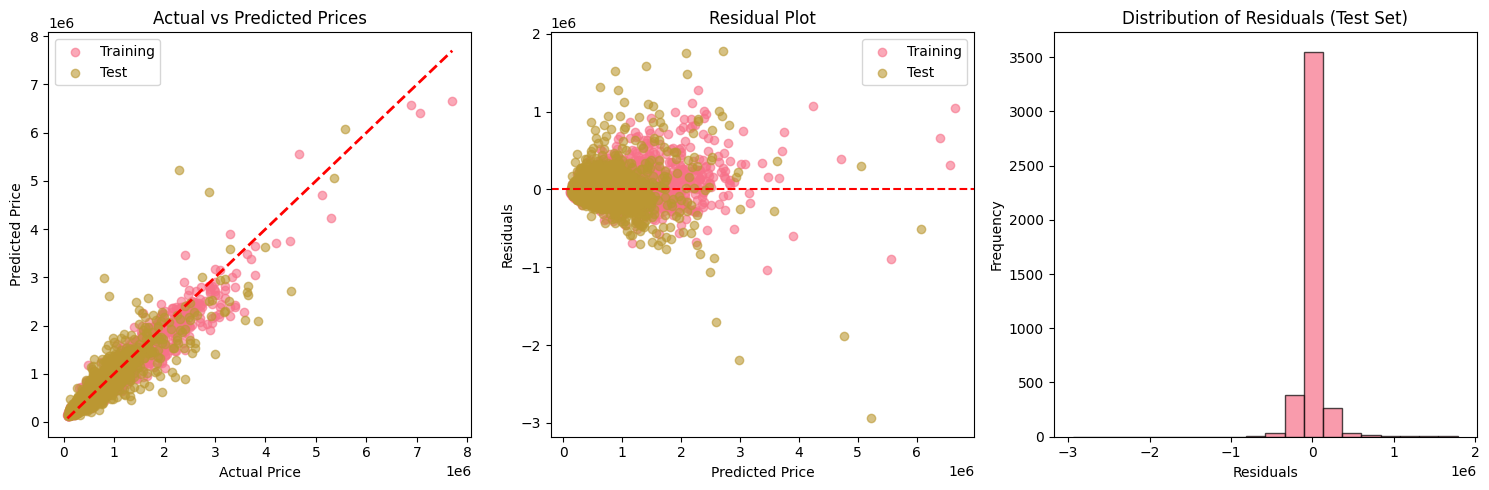

In [12]:
# Plot actual vs predicted
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, label='Training')
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()

plt.subplot(1, 3, 2)
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred
plt.scatter(y_train_pred, residuals_train, alpha=0.6, label='Training')
plt.scatter(y_test_pred, residuals_test, alpha=0.6, label='Test')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(residuals_test, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set)')

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# Buat DataFrame dengan data uji manual
data_uji = pd.DataFrame([
    {"price": 291850, "sqft_living": 1060, "grade": 7, "lat": 47.4095, "long": -122.315},
    {"price": 229500, "sqft_living": 1780, "grade": 7, "lat": 47.5123, "long": -122.337},
    {"price": 323000, "sqft_living": 1890, "grade": 7, "lat": 47.3684, "long": -122.031},
    {"price": 662500, "sqft_living": 3560, "grade": 8, "lat": 47.6007, "long": -122.145},
    {"price": 468000, "sqft_living": 1160, "grade": 7, "lat": 47.69,   "long": -122.292},
    {"price": 310000, "sqft_living": 1430, "grade": 7, "lat": 47.7558, "long": -122.229},
    {"price": 400000, "sqft_living": 1370, "grade": 7, "lat": 47.6127, "long": -122.045},
    {"price": 530000, "sqft_living": 1810, "grade": 7, "lat": 47.67,   "long": -122.394}
])

joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved!")

Scaler saved!


In [14]:
import joblib
import numpy as np

# Load scaler
scaler = joblib.load('scaler.pkl')
print("Scaler loaded!")

# Fungsi prediksi satuan
def predict_house_price(sqft_living, lat, grade, long, model, scaler=None):
    input_data = np.array([[sqft_living, lat, grade, long]])
    if scaler:
        input_data = scaler.transform(input_data)
    predicted_price = model.predict(input_data)[0]
    return predicted_price

# Fungsi batch prediksi
def predict_batch(df, model, scaler=None):
    df = df.copy()
    df['predicted_price'] = df.apply(
        lambda row: predict_house_price(
            row['sqft_living'],
            row['lat'],
            row['grade'],
            row['long'],
            model=model,
            scaler=scaler
        ),
        axis=1
    )
    df['error_rp'] = df['predicted_price'] - df['price']
    df['mape'] = (abs(df['error_rp']) / df['price']) * 100
    return df[['price', 'predicted_price', 'error_rp', 'mape']]

# Jalankan prediksi batch
hasil = predict_batch(data_uji, model=best_model, scaler=scaler)
print(hasil.to_string(index=False))


Scaler loaded!
 price  predicted_price      error_rp      mape
291850    236702.785377 -55147.214623 18.895739
229500    253884.670238  24384.670238 10.625129
323000    318371.548810  -4628.451190  1.432957
662500    741768.947972  79268.947972 11.965124
468000    484927.044524  16927.044524  3.616890
310000    334398.323720  24398.323720  7.870427
400000    389511.514603 -10488.485397  2.622121
530000    543590.061286  13590.061286  2.564163


Feature Importance (berdasarkan Random Forest):
       Feature  Importance
3         long    0.122309
1          lat    0.210074
0  sqft_living    0.332814
2        grade    0.334803


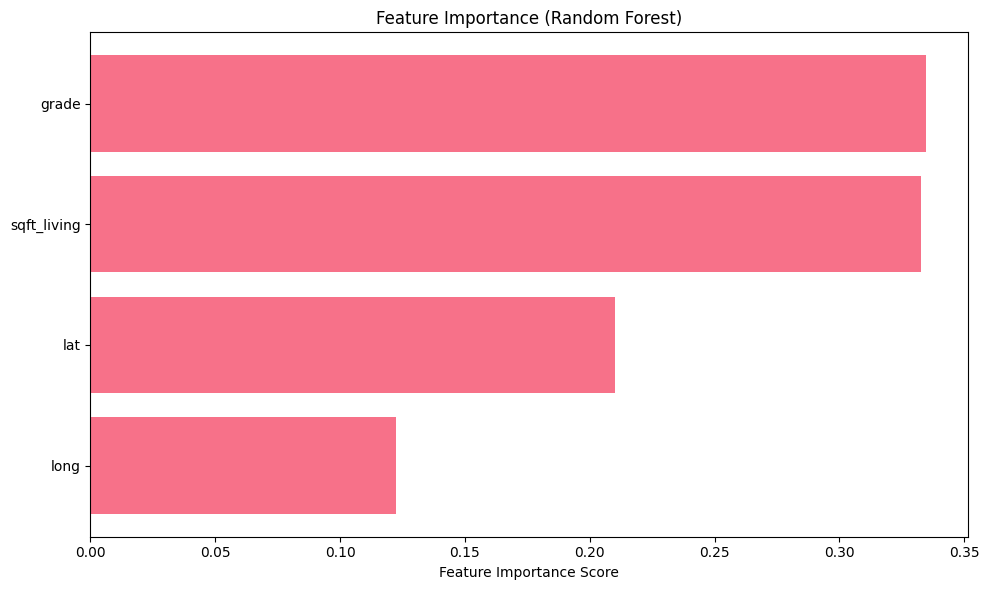

In [15]:
# Feature importance berdasarkan Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=True)

print("Feature Importance (berdasarkan Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
